# Automatic night input

This script lets you set the night in the database automatically. It uses the light sensor data to compute it.

If first shows the day/night graph and corresponding date/time and asks for confirmation on the value found.

| ![](../images/autonight.jpg) | 
|:--:| 
|Example of graph obtained with autonight. At the beginning of the experiment one can see the high lights while the experiment is starting, then the plateau when lights are on, and the 2nd plateau representing the night, and again on light phase **horizontal red line**:automatic threshold on light value. **pink zone**: dark phases found automatically, **gray zone (surimposed on pink in this example)**: dark phases previously existing in the sequence |

Code launched.
Processing file C:/Users/Fab/Desktop/Experiment 8466.sqlite
--------------
Current file:  C:/Users/Fab/Desktop/Experiment 8466.sqlite
night  Id( None , None , None , None ) Min/maxFrame: ( None / None ) Loaded ( 2  records loaded in  0.28600549697875977 S )
Loading animals.
Fields available in lmtanalysis:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:1 Name:A RFID:000004724298 Genotype:wt User1:None
Animal Id:2 Name:B RFID:000004724371 Genotype:wt User1:None
Animal Id:3 Name:C RFID:000004724516 Genotype:wt User1:None
Animal Id:4 Name:D RFID:000004724223 Genotype:wt User1:None
plotting sensor data.  LIGHTVISIBLEANDIR
night  Id( None , None , None , None ) Min/maxFrame: ( None / None ) Loaded ( 2  records loaded in  0.21300458908081055 S )
Skipping very short night phase. (less than 10 seconds)
Skipping very short night phase. (less than 10 seconds)
Skipping very short night phase. (less than 10 seconds

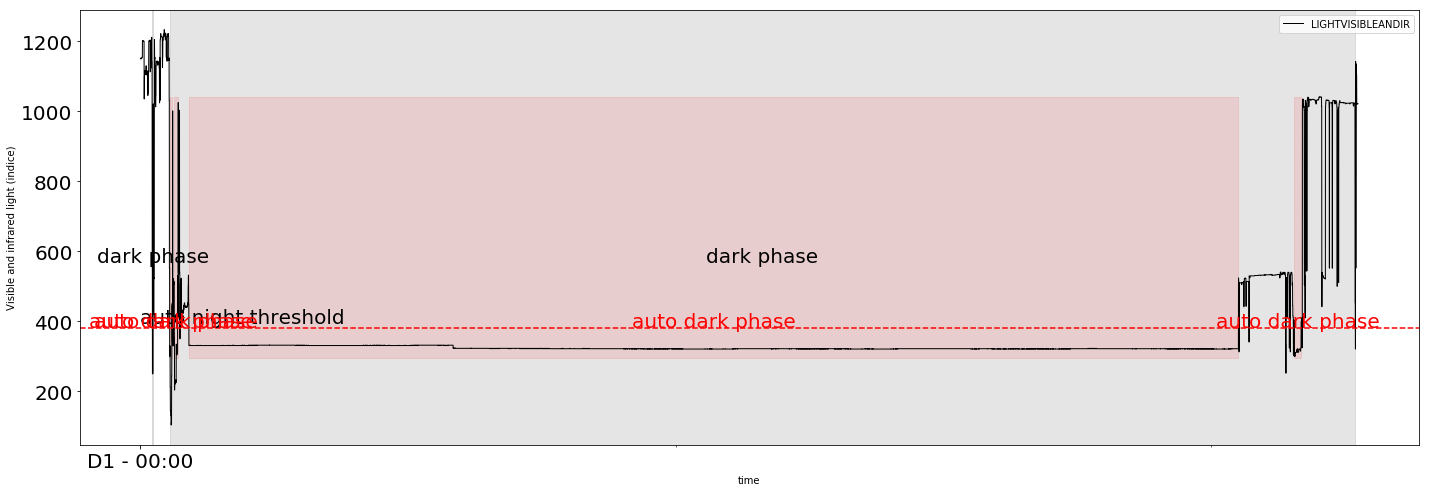

Night # 1
Starts at  11-06 (Jun)-2019 11:03:34
Ends at  11-06 (Jun)-2019 11:03:49
Night # 2
Starts at  11-06 (Jun)-2019 11:04:05
Ends at  11-06 (Jun)-2019 11:04:28
Night # 3
Starts at  11-06 (Jun)-2019 11:05:44
Ends at  11-06 (Jun)-2019 13:03:25
Night # 4
Starts at  11-06 (Jun)-2019 13:09:40
Ends at  11-06 (Jun)-2019 13:10:27
Set night(s) with autoNight data ? [Y/N]:y
Setting events...
night  Id( None , None , None , None ) Min/maxFrame: ( None / None ) Loaded ( 2  records loaded in  0.23000764846801758 S )
Number of event:  4
Mean length of event:  53591.75
first event frame:  5884
Delete old entry in base: night
Deleting event night (idA:None,idB:None,idC:None,idD:None) from base...
DELETE FROM EVENT WHERE NAME="night"
Number of event deleted: 2 
Saving timeLine: night ( 4 events )
Setting events... Done
*** ALL JOBS DONE ***


In [4]:
import sys
sys.path.insert(1, "../")

import sqlite3
from lmtanalysis.Animal import *
from lmtanalysis.Event import *
from lmtanalysis.Measure import *
from tkinter.filedialog import askopenfilename
import sys
from lmtanalysis.FileUtil import getFilesToProcess

class FileProcessException(Exception):
    pass

def getDateTime( animalPool, frame ):

    if frame > 0:
        
        datetime = getDatetimeFromFrame( animalPool.conn , frame )
        if datetime != None:
            realTime = getDatetimeFromFrame( animalPool.conn , frame ).strftime('%d-%m (%b)-%Y %H:%M:%S')
            return realTime
    return None


def process( file ):
    
    connection = sqlite3.connect( file )     

    print( "--------------")
    print( "Current file: ", file )
    
    nightTimeLine = EventTimeLine( connection, "night" , None, None, None , None )
    nightTimeLine.eventList.clear()
    
    connection = sqlite3.connect( file )
    # build sensor data
    animalPool = AnimalPool( )
    animalPool.loadAnimals( connection )
    autoNightList = animalPool.plotSensorData( 
        sensor = "LIGHTVISIBLEANDIR" , minValue = 40 , saveFile = file+"_log_light visible.pdf", show = True, autoNight = True  )
    
    # show nights 
    
    nightNumber = 1

    if autoNightList == None:
        print("No sensor data found.")
        return
        
    for autoNight in autoNightList:
    
        print( "Night #" , str( nightNumber ) )
        print( "Starts at " , getDateTime( animalPool , autoNight[0] ) )
        print( "Ends at " , getDateTime( animalPool, autoNight[1]) )
        
        nightNumber+=1
    
    # ask confirmation
        
    answer = input ("Set night(s) with autoNight data ? [Y/N]:")
    if answer.lower() == "y":
        print("Setting events...")
        
        nightTimeLine = EventTimeLine( connection, "night" , None, None, None , None )        
        nightTimeLine.eventList.clear()
              
        for autoNight in autoNightList:
            nightTimeLine.addEvent( Event( autoNight[0], autoNight[1] ) )
              
        nightTimeLine.endRebuildEventTimeLine(connection, deleteExistingEvent = True  )
        print("Setting events... Done")
    else:
        print("autoNight canceled.")
    
print("Code launched.")

files = getFilesToProcess()

if ( files != None ):

    for file in files:
        try:
            print ( "Processing file" , file )
            process( file )
        except FileProcessException:
            print ( "STOP PROCESSING FILE " + file , file=sys.stderr  )

print( "*** ALL JOBS DONE ***")